In [1]:
import numpy as np

In [2]:
import os
import jax, jax.numpy as jnp, jax.random as random
import matplotlib.pyplot as plt

In [ ]:
from precond_npe_misspec.examples.contaminated_weibull import (
    simulate,
    # true_dgp,
    ss_log,
    prior_sample,
)

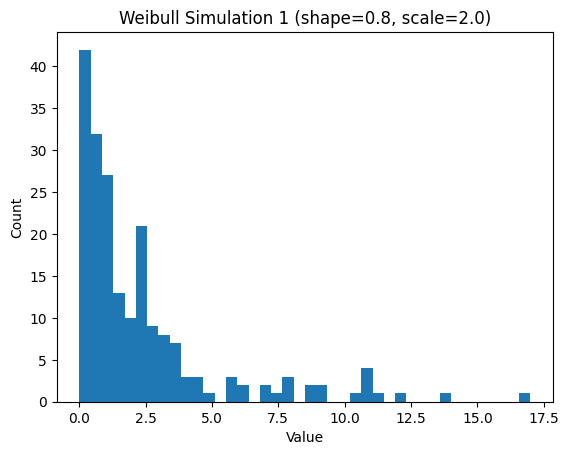

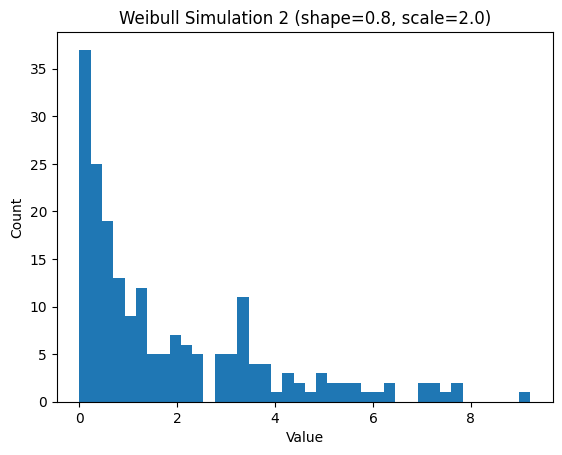

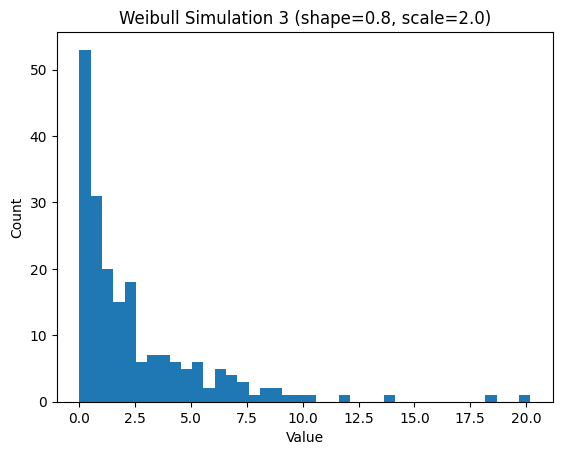

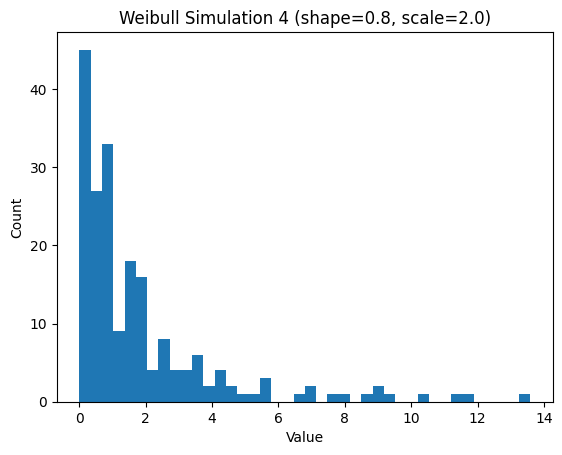

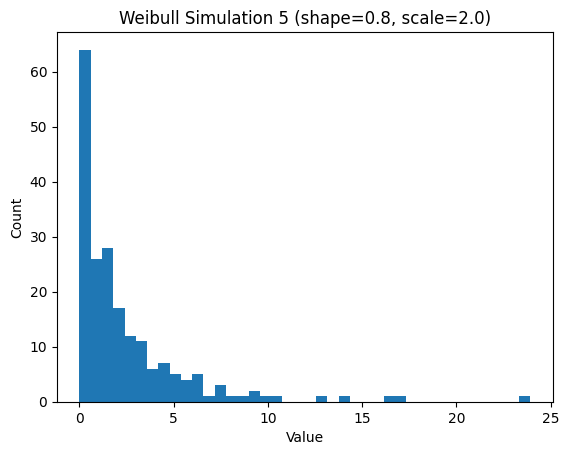

In [ ]:
# Simulate 1000 datasets from Weibull with shape=0.8, scale=2.0
n_obs = 200
sim_keys = jax.vmap(lambda i: random.fold_in(random.key(42), i))(
    jnp.arange(1000, dtype=jnp.uint32)
)
sim_theta = jnp.array([0.8, 2.0])
sim_X = jax.vmap(lambda k: simulate(k, sim_theta, n_obs=n_obs))(
    sim_keys
)  # (1000, n_obs)

# Plot histograms for a few simulations
for i in range(5):
    plt.figure()
    plt.hist(np.array(sim_X[i]), bins=40)
    plt.title(f"Weibull Simulation {i+1} (shape=0.8, scale=2.0)")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

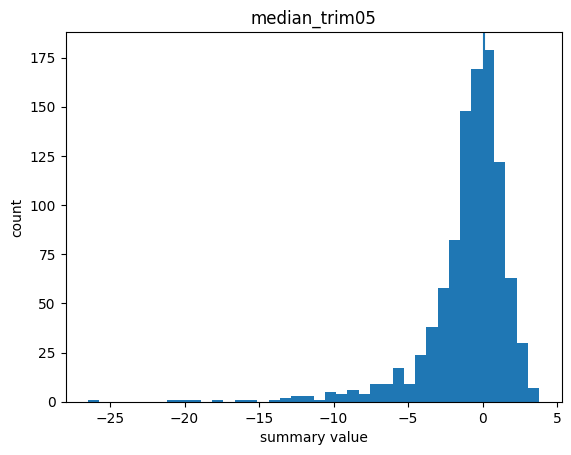

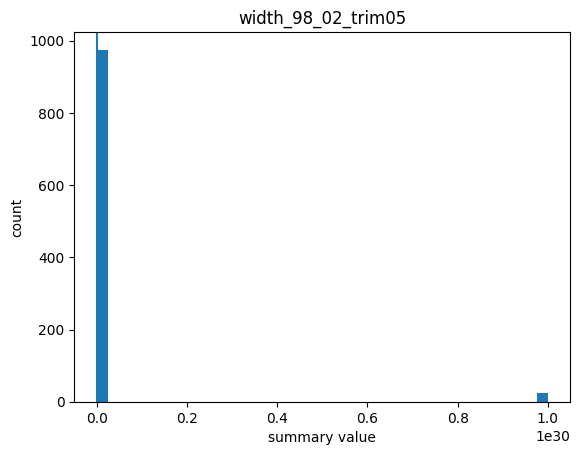

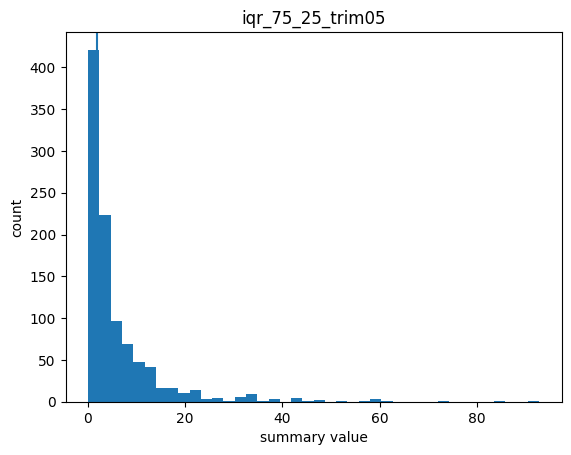

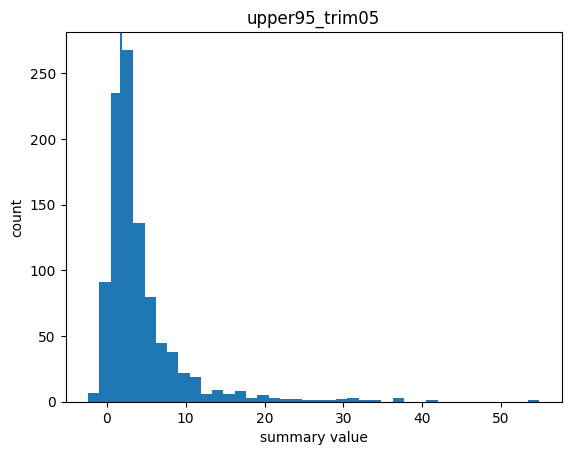

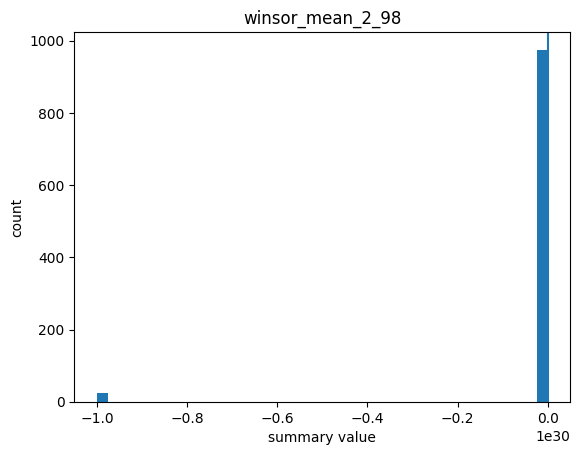

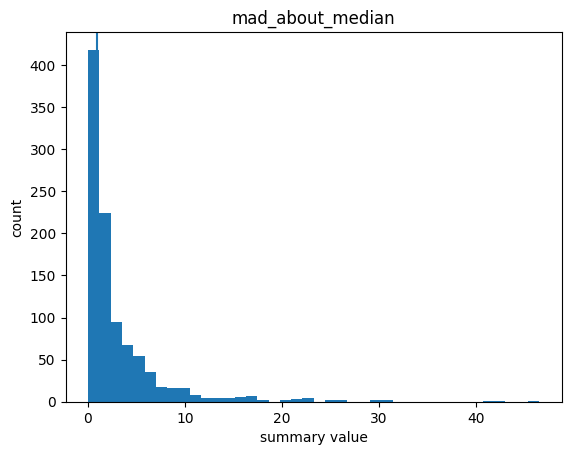

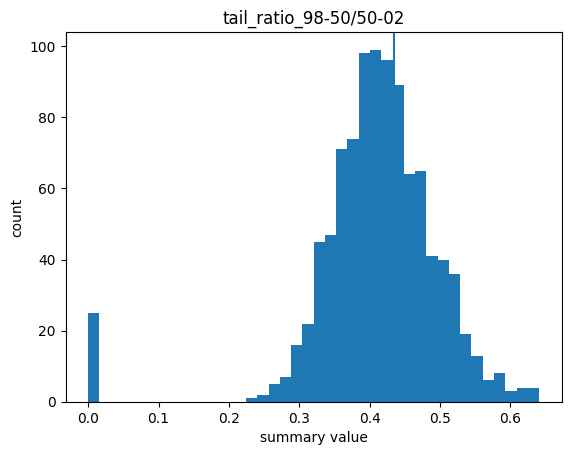

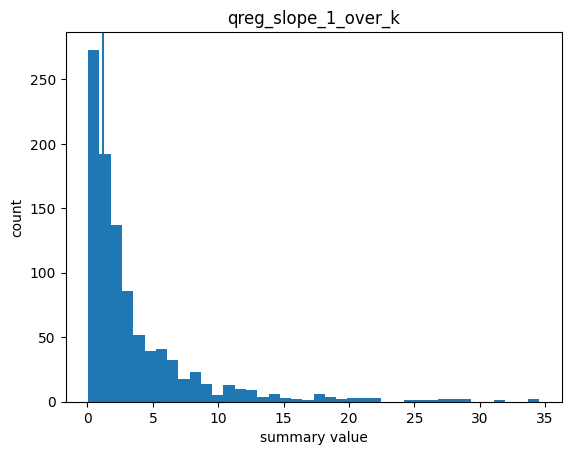

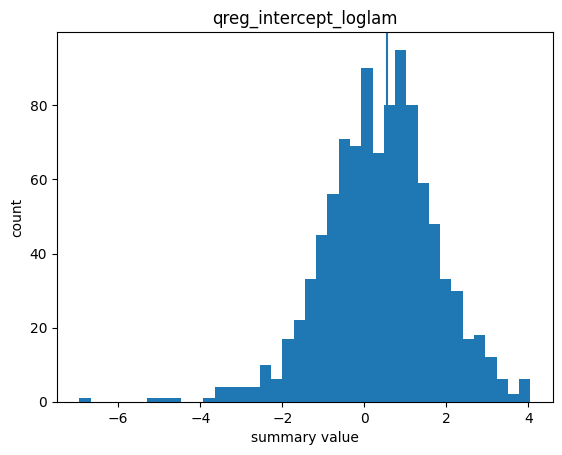

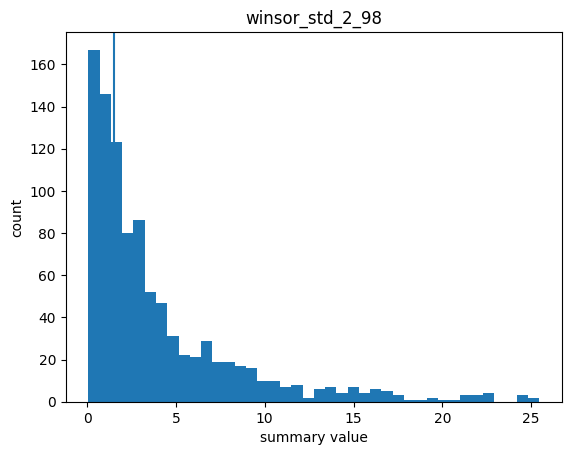

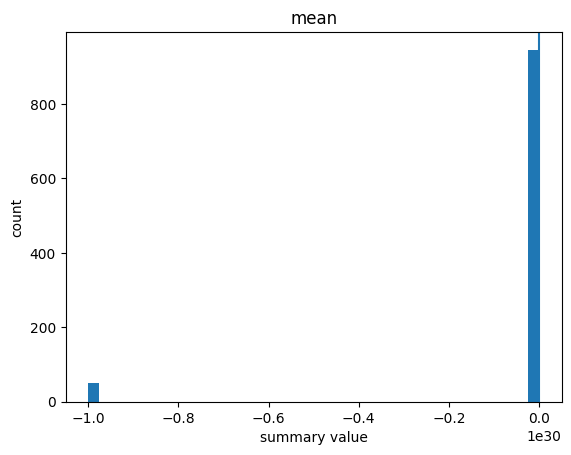

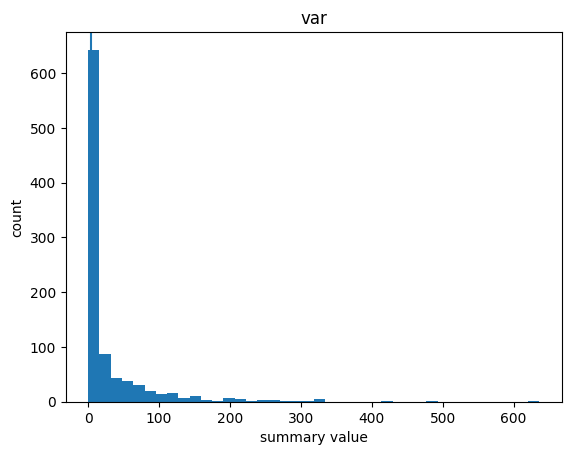

In [ ]:
def _trimmed_quants(x: jnp.ndarray, tau: float, ps_abs: jnp.ndarray) -> jnp.ndarray:
    # ps_abs are absolute levels in [0, 1 - tau]; we internally renormalise by (1 - tau)
    x = jnp.asarray(x)
    xs = jnp.sort(x)  # ascending
    n = xs.shape[0]  # static int
    m = jnp.ceil(tau * jnp.asarray(n, xs.dtype)).astype(jnp.int32)
    keep = jnp.maximum(n - m, 1)

    ps_abs = jnp.asarray(ps_abs, dtype=xs.dtype)
    ps_t = jnp.clip(ps_abs / (1.0 - tau), 0.0, 1.0)  # into [0,1]
    pos = ps_t * (keep - 1).astype(xs.dtype)
    lo = jnp.floor(pos).astype(jnp.int32)
    hi = jnp.minimum(lo + 1, keep - 1)
    w = pos - lo.astype(xs.dtype)
    return (1.0 - w) * xs[lo] + w * xs[hi]


def kept_q(x: jnp.ndarray, tau: float, r: float) -> jnp.ndarray:
    # r in (0,1) within-kept; map to absolute level (1 - tau)*r
    return _trimmed_quants(x, tau, (1.0 - tau) * jnp.asarray(r))


# ---- 10 candidate summaries (scalars) ----
def cand_median(x, tau=0.05):
    return kept_q(x, tau, 0.50)


def cand_width98_02(x, tau=0.05):
    return kept_q(x, tau, 0.98) - kept_q(x, tau, 0.02)


def cand_iqr(x, tau=0.05):
    return kept_q(x, tau, 0.75) - kept_q(x, tau, 0.25)


def cand_q95(x, tau=0.05):
    return kept_q(x, tau, 0.95)


def cand_winsor_mean(x, tau=0.05):
    lo, hi = kept_q(x, tau, 0.02), kept_q(x, tau, 0.98)
    return jnp.mean(jnp.clip(x, lo, hi))


def cand_mad(x, tau=0.05):
    med = kept_q(x, tau, 0.50)
    return jnp.median(jnp.abs(x - med))


def cand_tail_ratio(x, tau=0.05):
    med = kept_q(x, tau, 0.50)
    eps = 1e-8
    num = kept_q(x, tau, 0.98) - med
    den = med - kept_q(x, tau, 0.02)
    return num / (den + eps)


def cand_qreg_slope(x, tau=0.05):
    rs = jnp.array([0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9])  # avoid extremes
    zr = jnp.log(-jnp.log(1.0 - rs))
    qr = _trimmed_quants(x, tau, (1.0 - tau) * rs)
    zc = zr - zr.mean()
    qc = qr - qr.mean()
    varz = jnp.mean(zc**2) + 1e-12
    return jnp.mean(zc * qc) / varz  # ≈ 1/k


def cand_qreg_intercept(x, tau=0.05):
    rs = jnp.array([0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9])
    zr = jnp.log(-jnp.log(1.0 - rs))
    qr = _trimmed_quants(x, tau, (1.0 - tau) * rs)
    zc = zr - zr.mean()
    qc = qr - qr.mean()
    varz = jnp.mean(zc**2) + 1e-12
    slope = jnp.mean(zc * qc) / varz
    return qr.mean() - slope * zr.mean()  # ≈ log λ


def cand_winsor_std(x, tau=0.05):
    lo, hi = kept_q(x, tau, 0.02), kept_q(x, tau, 0.98)
    xc = jnp.clip(x, lo, hi)
    return jnp.std(xc)


candidates = [
    # ("median_trim05", cand_median),
    # ("width_98_02_trim05", cand_width98_02),
    # ("iqr_75_25_trim05", cand_iqr),
    # ("upper95_trim05", cand_q95),
    # ("winsor_mean_2_98", cand_winsor_mean),
    # ("mad_about_median", cand_mad),
    # ("tail_ratio_98-50/50-02", cand_tail_ratio),
    # ("qreg_slope_1_over_k", cand_qreg_slope),
    # ("qreg_intercept_loglam", cand_qreg_intercept),
    # ("winsor_std_2_98", cand_winsor_std),
    ("mean", lambda x, _: jnp.mean(x)),
    ("var", lambda x, _: jnp.var(x)),
]

# ---- prior predictive: 1000 datasets ----
N, n_obs, tau = 1000, 200, 0.05
key = random.key(0)
k_th, k_sm, k_obs = random.split(key, 3)
th_keys = jax.vmap(lambda i: random.fold_in(k_th, i))(jnp.arange(N, dtype=jnp.uint32))
thetas = jax.vmap(prior_sample)(th_keys)  # (N,2)
sm_keys = jax.vmap(lambda i: random.fold_in(k_sm, i))(jnp.arange(N, dtype=jnp.uint32))
X_prior = jax.vmap(lambda kk, th: simulate(kk, th, n_obs=n_obs))(
    sm_keys, thetas
)  # (N,n_obs)

# observed s_obs from the (possibly contaminated) true DGP
theta_true = jnp.array([0.8, 2.0])
x_obs = true_dgp(k_obs, theta_true, n_obs=n_obs, eps=0.05)

# ---- evaluate and plot ----
for name, fn in candidates:
    vals = jax.vmap(fn, in_axes=(0, None))(X_prior, tau)  # (N,)
    s_obs = fn(x_obs, tau)
    v = jnp.asarray(vals)
    v = jnp.clip(v, -1e30, 1e30)  # avoid plotting inf
    plt.figure()
    plt.hist(v, bins=40)
    plt.axvline(float(s_obs))
    plt.title(name)
    plt.xlabel("summary value")
    plt.ylabel("count")
    plt.show()